Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
100: VAE_SVM error=20.34 ; SVM error=25.49
600: VAE_SVM error=16.21 ; SVM error=20.14
1000: VAE_SVM error=15.21 ; SVM error=19.63
3000: VAE_SVM error=13.96 ; SVM error=17.75


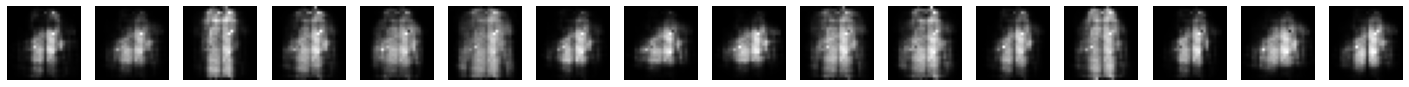

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from google.colab import drive
from torchvision.datasets import FashionMNIST
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import __or__
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn import svm
import joblib


def create_datasets(data_dir, batch_size=64, n_class=100, is_vae=False):
    if is_vae:
        trans=lambda x: transforms.ToTensor()(x).view(-1).bernoulli()
    else:
        trans=lambda x: transforms.ToTensor()(x).view(-1)
    train_set = FashionMNIST(data_dir, download=True, train=True, transform=trans)
    test_set = FashionMNIST(data_dir, download=True, train=False, transform=lambda x: transforms.ToTensor()(x).view(-1))
    return train_set, test_set


def calc_sampler(y, n=None):
    (indexes,) = np.where(reduce(__or__, [y == i for i in np.arange(n_labels)]))
    np.random.shuffle(indexes)
    indexes = np.hstack([list(filter(lambda idx: y[idx] == i, indexes))[:n] for i in range(n_labels)])
    return SubsetRandomSampler(torch.from_numpy(indexes))


def load_data(trainset, testset, batch_size, is_vae=False, n_class=0):
    if is_vae:
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    else:
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, pin_memory='cuda',
                                                   sampler=calc_sampler(trainset.targets.numpy(), n_class))
        test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, pin_memory='cuda')
    return train_loader, test_loader


class GaussianDistSample(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.log_variance = nn.Linear(in_features, out_features)
        self.mu = nn.Linear(in_features, out_features)

    def calc_z(self, mu, log_variance):
        eps = Variable(torch.randn(mu.size()), requires_grad=False)
        if mu.is_cuda:
            eps = eps.cuda()
        return mu.addcmul(log_variance.mul(0.5).exp_(), eps)

    def forward(self, x):
        mu = self.mu(x)
        log_variance = F.softplus(self.log_variance(x))
        return self.calc_z(mu, log_variance), mu, log_variance


class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_layers_dim_list):
        super().__init__()
        neurons_list = [input_dim, *hidden_layers_dim_list]
        self.fc_model = nn.ModuleList([nn.Linear(neurons_list[i], neurons_list[i+1]) for i in range(len(neurons_list) - 1)])
        self.gaussian_sample = GaussianDistSample(hidden_layers_dim_list[-1], latent_dim)

    def forward(self, x):
        for fc_layer in self.fc_model:
            x = F.relu(fc_layer(x))
        return self.gaussian_sample(x)


class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_layers_dim_list):
        super().__init__()
        reverse_hidden_layers_list = hidden_layers_dim_list[::-1]
        neurons_list = [latent_dim, *reverse_hidden_layers_list]
        self.fc_model = nn.ModuleList([nn.Linear(neurons_list[i], neurons_list[i+1]) for i in range(len(neurons_list) - 1)])
        self.fc_last = nn.Linear(reverse_hidden_layers_list[-1], input_dim)
        self.output = nn.Sigmoid()

    def forward(self, x):
        for fc_layer in self.fc_model:
            x = F.relu(fc_layer(x))
        return self.output(self.fc_last(x))


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_layers_dim_list):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim, hidden_layers_dim_list)
        self.decoder = Decoder(input_dim, latent_dim, hidden_layers_dim_list)
        self.kld = 0

        for module in self.modules():
            if not isinstance(module, nn.Linear):
                continue
            nn.init.xavier_normal_(module.weight.data)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x, y=None):
        latent, mu, log_variance = self.encoder(x)
        self.kld =  -0.5 * torch.sum(-log_variance.exp() + log_variance + 1 - mu.pow(2), axis= -1)
        out_mu = self.decoder(latent)
        return out_mu

    def sample(self, latent):
        return self.decoder(latent)

def train_vae_model(num_epochs, model, train_data, optimizer, loss_function):
    for epoch in range(num_epochs):
        model.train()
        total_loss, counter = 0, 0
        for _, (x, _) in enumerate(train_data):
            counter += x.size()[0]
            x = x.to(device)
            optimizer.zero_grad()
            x_reconstructed = model(x)
            loss = torch.mean(loss_function(x_reconstructed, x) + model.kld)
            loss.backward()
            optimizer.step()
            total_loss += loss.data.cpu().numpy()
        model.eval()
        print(f"Epoch {epoch + 1}/{num_epochs} : Loss {total_loss / counter}")
    return model

def test_vae_model(model):
    model.eval()
    generated_latent = Variable(torch.randn(16, 50))
    generated_latent = generated_latent.cuda(device=0)
    x_reconstructed = model.sample(generated_latent)
    x_reconstructed = x_reconstructed.cpu()
    samples = x_reconstructed.data.view(-1, 28, 28).numpy()
    _, axis_arr = plt.subplots(1, 16, figsize=(25, 25))
    for i, ax in enumerate(axis_arr.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis("off")


def save_vae_model(net_model, net_weights_dir):
    weights_path = f"{net_weights_dir}/vae.pt"
    torch.save(net_model.state_dict(), weights_path)


def load_vae_model(net_weights_dir):
    weight_path = f"{net_weights_dir}/vae.pt"
    net_model = torch.load(weight_path)
    return net_model


def svm_error(svm_model, x, y):
    pred = svm_model.predict(x)
    return ((pred != y).astype(int).sum()) * 100 / pred.shape[0]


def get_data(data_loader, model):
    input, latent, output = list(), list(), list()
    for x, y in data_loader:
        input.append(x.numpy().squeeze())
        output.append(y.numpy().squeeze())
        x = x.to(device)
        encoded, _, _ = model.encoder(x)
        latent.append(encoded.data.cpu().detach().numpy().squeeze())
    return input, latent, output


def train_or_test_svm_model(data_train, data_test, model, batch_size, is_train=True, seed=0):
    for labels_number in [100, 600, 1000, 3000]:
        labelled_data, validation_data = load_data(data_train, data_test, batch_size, n_class=labels_number)
        input, latent, output = get_data(labelled_data, model)
        input_test, latent_test, output_test = get_data(validation_data, model)
        if is_train:
            svm_model = svm.SVC(kernel='rbf', random_state=seed)
            svm_model.fit(input, output)
            error_svm = svm_error(svm_model, input_test, output_test)
            weights_path = f"{models_dir}/vae_svm_{labels_number}.pt"
            joblib.dump(svm_model, weights_path)
            svm_model = svm.SVC(kernel='rbf', random_state=seed)
            svm_model.fit(latent,output)
            latent_svm_error = svm_error(svm_model, latent_test, output_test)
            weigths_path = f"{models_dir}/svm_{labels_number}.pt"
            joblib.dump(svm_model, weigths_path)
        else:
            weights_path = f"{models_dir}/vae_svm_{labels_number}.pt"
            svm_model = joblib.load(weights_path)
            error_svm = svm_error(svm_model, input_test, output_test)
            weights_path = f"{models_dir}/svm_{labels_number}.pt"
            svm_model = joblib.load(weights_path)
            latent_svm_error = svm_error(svm_model, latent_test, output_test)
        print(f"{labels_number}: VAE_SVM error={latent_svm_error} ; SVM error={error_svm}")
  

class VAETasks:
    train_vae_net = 1
    test_vae_net = 2


class SVMTasks:
    none = 0
    train_svm = 1
    test_svm = 2

########## USER CONTROL ##########
vae_task = VAETasks.test_vae_net
svm_task = SVMTasks.test_svm
########## USER CONTROL ##########


drive.mount('/content/drive')
root_dir = "/content/drive/Shared drives/Deep Learning Course/ex3_204094213_301861902/Q3"
data_dir = f"{root_dir}/data"
models_dir = f"{root_dir}/net_weights"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 100
num_epochs = 100
latent_dim = 50
hidden_layers_list = [600, 600]
input_dim = 784

trainset, testset = create_datasets(data_dir, is_vae=True)
train_loader, test_loader = load_data(trainset, testset, batch_size, is_vae=True)

model = VAE(input_dim, latent_dim, hidden_layers_list)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=0.01)
loss_function = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='sum')

if vae_task == VAETasks.train_vae_net:
    model = train_vae_model(num_epochs, model, train_loader, optimizer, loss_function)
    save_vae_model(model, models_dir)

elif vae_task == VAETasks.test_vae_net:
    saved_weights = load_vae_model(models_dir)
    model.load_state_dict(saved_weights)
    test_vae_model(model)

n_labels = 10
batch_size = 1
seed = 0
if svm_task != SVMTasks.none:
    train_or_test_svm_model(trainset, testset, model, batch_size, svm_task == SVMTasks.train_svm)
